In [1]:
import collections
import math
import tensorflow as tf
from Dive_into_deep_learning.d2l import tensorflow as d2l

2023-08-11 13:43:40.380275: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class Seq2SeqEncoder(d2l.Encoder):
    """The RNN encoder for sequence to sequence learning"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(num_hiddens, num_layers, dropout)
        
    def call(self, X, *args):
        # X shape: (bath_size, num_steps)
        embs = self.embedding(tf.transpose(X))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

In [5]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = tf.zeros((batch_size, num_steps))
enc_outputs, enc_state = encoder(X)
d2l.check_shape(enc_outputs, (num_steps, batch_size, num_hiddens))
d2l.check_len(enc_state, num_layers)
d2l.check_shape(enc_state[0], (batch_size, num_hiddens))

In [0]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(num_hiddens, num_layers, dropout)
        self.dense = tf.keras.layers.Dense(vocab_size)
        
    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs
    
    def call(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(tf.transpose(X))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = tf.tile(tf.expand_dims(context, 0), (embs.shape[0], 1, 1))
        # Concat at the feature dimension
        embs_and_context = tf.concat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = tf.transpose(self.dense(outputs), (1, 0, 2))
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

In [12]:
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)
d2l.check_shape(dec_outputs, (batch_size, num_steps, vocab_size))
d2l.check_len(state[1], num_layers)
d2l.check_shape(state[1][0], (batch_size, num_hiddens))

In [13]:
class Seq2Seq(d2l.EncoderDecoder):
    """The RNN encoder-decoder for sequence learning"""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()
        
    def validation(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        
    def configure_optimizers(self):
        # Adam optimizer is used here
        return tf.keras.optimizers.Adam(learning_rate=self.lr)

    def loss(self, Y_hat, Y):
        l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
        mask = tf.cast(tf.reshape(Y, -1) != self.tgt_pad, tf.float32)
        return tf.reduce_sum(l * mask) / tf.reduce_sum(mask)

KeyboardInterrupt: 

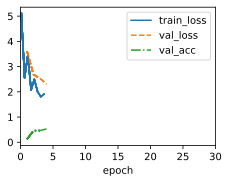

In [14]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
with d2l.try_gpu():
    encoder = Seq2SeqEncoder(
        len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
    decoder = Seq2SeqDecoder(
        len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
    model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1)
trainer.fit(model, data)